## Introdução

Neste caderno, aprenderemos tudo sobre Random Forests, construindo uma do zero e usando-a para participar da competição do Titanic!

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Pré-processamento de dados

Criaremos `DataFrame`s a partir dos arquivos CSV:

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

No entanto, uma diferença com Random Forests é que geralmente não precisamos criar *variáveis fictícias* (dummy) como fizemos para colunas não numéricas nos modelos lineares e na rede neural. Em vez disso, podemos apenas converter esses campos em *variáveis categóricas*, que internamente no Pandas faz uma lista de todos os valores exclusivos na coluna e substitui cada valor por um número. O número é apenas um índice para pesquisar o valor na lista de todos os valores exclusivos.

In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

Faremos uma lista das variáveis contínuas, categóricas e dependentes. Observe que não consideramos mais `Pclass` uma variável categórica. Isso ocorre porque ela é *ordenada* (ou seja, 1ª, 2ª e 3ª classes têm uma ordem) e as árvores de decisão, como veremos, só se preocupam com a ordem, não com o valor absoluto.

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

Embora tenhamos tornado as colunas `cats` categóricas, elas ainda são mostradas pelo Pandas como seus valores originais:

In [5]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

No entanto, nos bastidores, eles agora são armazenados como números inteiros, com índices que são pesquisados na lista `Categories` mostrada na saída acima. Podemos ver os valores armazenados procurando no atributo `cat.codes`:

In [6]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

## Divisões binárias

Antes de criarmos uma Random Forest ou Gradient Boosting Machine, primeiro precisamos aprender como criar uma *árvore de decisão*, a partir da qual ambos os modelos são construídos.

E para criar uma árvore de decisão, primeiro precisamos criar uma *divisão binária*, pois é a partir dela que uma árvore de decisão é construída.

Uma divisão binária é onde todas as linhas são colocadas em um dos dois grupos, com base em estarem acima ou abaixo de algum limite de alguma coluna. Por exemplo, podemos dividir as linhas do nosso conjunto de dados em masculinos e femininos, usando o limite `0.5` e a coluna `Sex` (uma vez que os valores na coluna são `0` para `female` e `1` para `male`). Podemos usar um gráfico para ver como isso dividiria nossos dados:

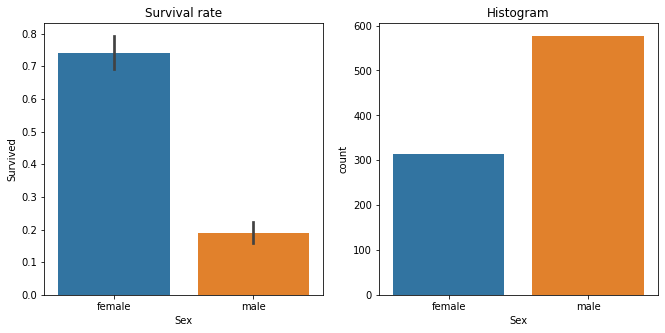

In [7]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Aqui vemos que (à esquerda) se dividirmos os dados em masculinos e femininos, teremos grupos com taxas de sobrevivência muito diferentes: >70% para mulheres e <20% para homens. Também podemos ver (à direita) que a divisão seria razoavelmente equilibrada, com mais de 300 passageiros (de cerca de 900) em cada grupo.

Poderíamos criar um "modelo" muito simples que simplesmente diga que todas as mulheres sobrevivem e nenhum homem sobrevive. Para fazer isso, é melhor primeiro dividir nossos dados em um conjunto de treinamento e validação, para ver a precisão dessa abordagem:

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

(Na etapa anterior, também substituímos as variáveis categóricas por seus códigos inteiros, pois alguns dos modelos que construiremos daqui a pouco exigem isso.)

Agora podemos criar nossas variáveis independentes (as variáveis `x`) e dependente(a variável `y`):

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Aqui estão as previsões para nosso modelo extremamente simples, onde `female` é codificado como `0`:

In [10]:
preds = val_xs.Sex==0

Usaremos o erro absoluto médio para medir a qualidade desse modelo:

In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

Como alternativa, podemos tentar dividir em uma coluna contínua. Temos que usar um gráfico um pouco diferente para ver como isso pode funcionar - aqui está um exemplo de como poderíamos olhar para `LogFare`:

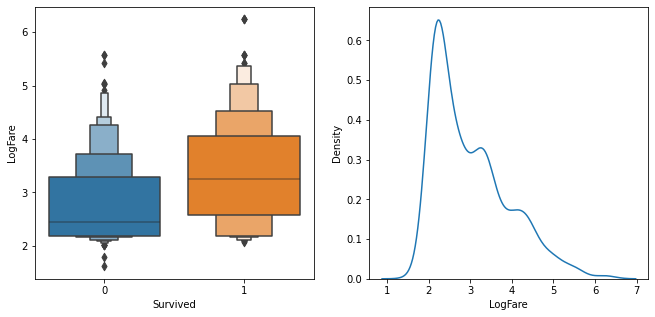

In [12]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

O [boxenplot] acima mostra quantis de `LogFare` para cada grupo de `Survived==0` e `Survived==1`. Ele mostra que o `LogFare` médio para os passageiros que não sobreviveram é de cerca de `2,5`, e para os que sobreviveram é de cerca de `3,2`. Portanto, parece que as pessoas que pagaram mais por suas passagens tinham mais chances de serem colocadas em um bote salva-vidas.

Vamos criar um modelo simples com base nesta observação:

In [13]:
preds = val_xs.LogFare>2.7

... e testar:

In [14]:
mean_absolute_error(val_y, preds)

0.336322869955157

Isso é um pouco menos preciso do que nosso modelo que usou `Sex` como a divisão binária única.

Idealmente, gostaríamos de experimentar mais colunas e pontos de interrupção com mais facilidade. Poderíamos criar uma função que retorne a qualidade do nosso modelo, a fim de experimentar mais rapidamente algumas divisões diferentes. Vamos criar uma função `score` para fazer isso. Em vez de retornar o erro absoluto médio, calcularemos uma medida de *impureza* -- ou seja, quanto a divisão binária cria dois grupos em que as linhas de um grupo são semelhantes entre si ou diferentes.

Podemos medir a similaridade das linhas dentro de um grupo tomando o desvio padrão da variável dependente. Se for maior, significa que as linhas são mais diferentes umas das outras. Em seguida, multiplicaremos isso pelo número de linhas, pois um grupo maior causa mais impacto do que um grupo menor:

In [15]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Agora que temos isso escrito, podemos calcular a pontuação para uma divisão somando as pontuações para o "lado esquerdo" (lhs) e "lado direito" (rhs):

In [16]:
    
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

Por exemplo, aqui está a pontuação de impureza para a divisão em `Sex`:

In [17]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

...e para `LogFare`:

In [18]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

Como esperávamos de nossos testes anteriores, `Sex` parece ser uma divisão melhor.

Para facilitar a localização da melhor divisão binária, podemos criar uma ferramenta interativa simples (observe que isso só funciona no Kaggle se você clicar em "Copiar e Editar" no canto superior direito para abrir o editor de notebook):

In [19]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

Tente selecionar diferentes colunas e pontos de divisão usando o menu suspenso e o controle deslizante acima. Quais divisões você pode encontrar que aumentam a pureza dos dados?

Podemos fazer o mesmo para as variáveis categóricas:

In [20]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

Isso funciona bem o suficiente, mas é bastante lento e complicado. Talvez possamos fazer com que o computador encontre automaticamente o melhor ponto de divisão para uma coluna para nós? Por exemplo, para encontrar o melhor ponto de divisão para `idade`, primeiro precisamos fazer uma lista de todos os pontos de divisão possíveis (ou seja, todos os valores únicos desse campo)...:

In [21]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

...e encontre qual índice desses valores é onde `score()` é o mais baixo:

In [22]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

Com base nisso, parece, por exemplo, que para a coluna `Idade`, `6` é o corte ideal de acordo com nosso conjunto de treinamento.

Podemos escrever uma pequena função que implementa essa ideia:

In [23]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

Vamos tentar todas as colunas:

In [24]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

De acordo com isso, `Sex<=0` é a melhor divisão que podemos usar.

Acabamos de reinventar o classificador [OneR](https://link.springer.com/article/10.1023/A:102263118932) (ou, pelo menos, uma variante menor dele), que foi considerado um dos classificadores mais eficazes em conjuntos de dados do mundo real, em comparação com os algoritmos em uso em 1993. Como é tão simples e surpreendentemente eficaz, é uma ótima *linha de base* -- ou seja , um ponto de partida que você pode usar para comparar seus modelos mais sofisticados.

Descobrimos anteriormente que nossa regra OneR tinha um erro de cerca de `0,215`, portanto, manteremos isso em mente ao tentarmos abordagens mais sofisticadas.

## Criando uma árvore de decisão

Como podemos melhorar nosso classificador OneR, que prevê a sobrevivência com base apenas em `Sexo`?

Que tal pegarmos cada um dos nossos dois grupos, `female` e `male`, e criarmos mais uma divisão binária para cada um deles. Ou seja: multa a melhor divisão individual para mulheres e a melhor divisão individual para homens. Para fazer isso, basta repetir os passos da seção anterior, uma vez para os machos e outra para as fêmeas.

Primeiro, removeremos `Sex` da lista de divisões possíveis (já que já o usamos e há apenas uma divisão possível para essa coluna binária) e criaremos nossos dois grupos:

In [25]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

Agora vamos encontrar a melhor divisão binária para homens...:

In [26]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

...e para mulheres:

In [27]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

Podemos ver que a melhor próxima divisão binária para homens é `Age<=6`, e para mulheres é `Pclass<=2`.

Ao adicionar essas regras, criamos uma *árvore de decisão*, onde nosso modelo verificará primeiro se `Sex` é feminino ou masculino e, dependendo do resultado, verificará as regras acima `Age` ou `Pclass`, conforme apropriado. Poderíamos então repetir o processo, criando novas regras adicionais para cada um dos quatro grupos que criamos agora.

Em vez de escrever esse código manualmente, podemos usar `DecisionTreeClassifier`, de *sklearn*, que faz exatamente isso para nós:

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

Um recurso útil dessa classe é que ela fornece uma função para desenhar uma árvore representando as regras:

In [29]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

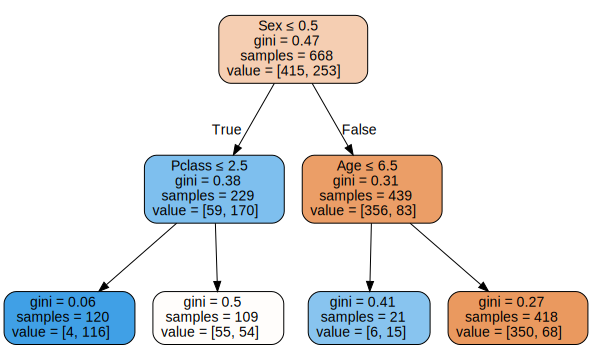

In [30]:
draw_tree(m, trn_xs, size=10)

Podemos ver que ele encontrou exatamente as mesmas divisões que fizemos!

Nesta imagem, os nós mais laranjas têm menor taxa de sobrevivência e os azuis têm maior sobrevivência. Cada nó mostra quantas linhas ("*amostras*") correspondem a esse conjunto de regras e mostra quantas perecem ou sobrevivem ("*valores*"). Há também algo chamado "*gini*". Essa é outra medida de impureza e é muito semelhante ao `score()` que criamos anteriormente. É definido da seguinte forma:

In [31]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

O que isso calcula é a probabilidade de que, se você escolher duas linhas de um grupo, obterá o mesmo resultado `Sobreviveu` todas as vezes. Se o grupo for todo igual, a probabilidade é `1.0`, e `0.0` se forem todos diferentes:

In [32]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

Vamos ver como este modelo se compara à nossa versão OneR:

In [33]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

É um pouco pior. Como este é um conjunto de dados tão pequeno (temos apenas cerca de 200 linhas em nosso conjunto de validação), essa pequena diferença não é realmente significativa. Talvez vejamos melhores resultados se criarmos uma árvore maior:

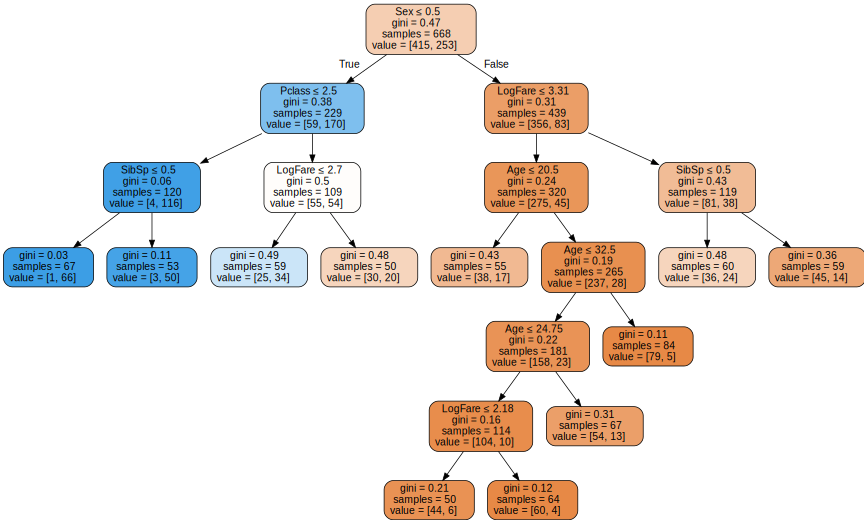

In [34]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [35]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

Parece que isso é uma melhoria, embora, novamente, seja um pouco difícil dizer com pequenos conjuntos de dados como esse. Vamos tentar enviá-lo para o Kaggle:

In [36]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

Quando enviei isso, obtive uma pontuação de 0,765, que não é tão boa quanto nossos modelos lineares ou a maioria de nossas redes neurais, mas está bem próxima desses resultados.

Espero que agora você possa ver por que realmente não precisamos criar variáveis fictícias, mas apenas converter os rótulos em números usando alguma ordem (potencialmente arbitrária) de categorias. Por exemplo, veja como os primeiros itens de `Embarked` são rotulados:

In [37]:
df.Embarked.head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

...resultando nestes códigos inteiros:

In [38]:
df.Embarked.cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

Então, digamos que queremos dividir em "C" em um grupo, contra "Q" ou "S" no outro grupo. Então só temos que dividir em códigos `<=0` (já que `C` é mapeado para a categoria `0`). Observe que, se quiséssemos dividir em "Q" em um grupo, precisaríamos usar duas divisões binárias, primeiro para separar "C" de "Q" e "S" e, em seguida, uma segunda divisão para separar "Q" de "S". Por esse motivo, às vezes ainda pode ser útil usar variáveis fictícias para variáveis categóricas com poucos níveis (como esta).

Na prática, costumo usar variáveis fictícias para <4 níveis e códigos numéricos para >=4 níveis.

## A floresta aleatória

Não podemos tornar a árvore de decisão muito maior do que o exemplo acima, pois alguns nós folha já possuem apenas 50 linhas. Isso não é um monte de dados para fazer uma previsão.

Então, como poderíamos usar árvores maiores? Um grande insight veio de Leo Breiman: e se criarmos muitas árvores maiores e tirarmos a média de suas previsões? Obter a previsão média de vários modelos dessa maneira é conhecido como [bagging](https://link.springer.com/article/10.1007/BF00058655).

A ideia é que queremos que as previsões de cada modelo no conjunto médio não sejam correlacionadas entre si. Dessa forma, se fizermos a média das previsões, a média será igual ao verdadeiro valor alvo -- isso porque a média de muitos erros aleatórios não correlacionados é zero. Essa é uma visão incrível!

Uma maneira de criar vários modelos não correlacionados é treinar cada um deles em um subconjunto aleatório diferente dos dados. Veja como podemos criar uma árvore em um subconjunto aleatório dos dados:

In [39]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Agora podemos criar quantas árvores quisermos:

In [40]:
trees = [get_tree() for t in range(100)]

Nossa previsão será a média das previsões dessas árvores:

In [41]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

Isso é quase idêntico ao que o `RandomForestClassifier` do `sklearn` faz. A principal peça extra em uma floresta aleatória "real" é que, além de escolher uma amostra aleatória de dados para cada árvore, ela também escolhe um subconjunto aleatório de colunas para cada divisão. Veja como repetimos o processo acima com uma floresta aleatória:

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

Também podemos enviar isso para o Kaggle:

In [43]:
subm(rf.predict(tst_xs), 'rf')

Descobri que deu um resultado quase idêntico ao da nossa árvore única (que, por sua vez, foi ligeiramente inferior aos nossos modelos lineares e de rede neural no notebook anterior).

Uma característica particularmente interessante das florestas aleatórias é que elas podem nos dizer quais variáveis independentes foram as mais importantes no modelo, usando `feature_importances_`:

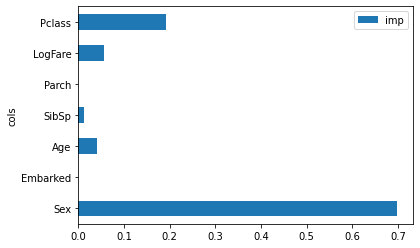

In [44]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Podemos ver que `Sex` é de longe o preditor mais importante, com `Pclass` em um distante segundo lugar, e `LogFare` e `Age` atrás disso. Em conjuntos de dados com muitas colunas, geralmente recomendo criar um gráfico de importância de recurso o mais rápido possível, a fim de descobrir quais colunas valem a pena estudar mais de perto. (Observe também que realmente não precisamos pegar o `log()` de `Fare`, já que florestas aleatórias só se preocupam com a ordem, e `log()` não altera a ordem -- nós apenas fizemos isso para tornar nossos gráficos anteriores mais fáceis de ler.)